In [1]:
%load_ext autoreload
%autoreload 2

import intake
import os
import zarr
import pandas as pd
import xarray as xr
import intake_esm
import numpy as np
from dask.distributed import Client
from cmip6_downscaling import CLIMATE_NORMAL_PERIOD
from cmip6_downscaling.constants import KELVIN, PERCENT, SEC_PER_DAY
from cmip6_downscaling.workflows.share import (
    chunks,
    future_time,
    get_cmip_runs,
    hist_time,
    xy_region,
)
from cmip6_downscaling.workflows.utils import get_store
intake_esm.__version__

'2021.8.17'

In [2]:
import skdownscale

In [3]:
skdownscale.__file__

'/home/jovyan/scikit-downscale/skdownscale/__init__.py'

In [ ]:
variable = 'tasmax'

# access GCM data

In [4]:
activity_ids = ["CMIP", "ScenarioMIP"]
experiment_ids = ["historical", "ssp370"] #, "ssp126", "ssp245",  "ssp585"
member_ids = ["r1i1p1f1"]
source_ids = ["CanESM5"]#BCC-CSM2-MR"]
table_ids = ["day"]
grid_labels = ["gn"]
variable_ids = [variable] #tasmax, tasmin, pr

In [25]:
col_url = "https://cmip6downscaling.blob.core.windows.net/cmip6/pangeo-cmip6.json"

col = intake.open_esm_datastore(col_url)
full_subset = col.search(
    activity_id=activity_ids,
    experiment_id=experiment_ids, 
    member_id=member_ids,
    table_id=table_ids,
    grid_label=grid_labels,
    variable_id=variable_ids,
    source_id=source_ids
)

In [26]:
gcm_ds_dict = full_subset.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}, 
    storage_options={'account_name':'cmip6downscaling',
                     'account_key':os.environ.get('AccountKey', None)}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [27]:
gcm_ds_dict.keys()

dict_keys(['ScenarioMIP.CCCma.CanESM5.ssp370.day.gn', 'CMIP.CCCma.CanESM5.historical.day.gn'])

# access obs data

In [8]:
# converts cmip standard names to ERA5 names
variable_name_dict = {
    'tasmax': 'air_temperature_at_2_metres_1hour_Maximum',
    'tasmin': 'air_temperature_at_2_metres_1hour_Minimum',
    'pr': 'precipitation_amount_1hour_Accumulation'
}

In [12]:
def get_store(bucket, prefix, account_key=None):
    ''' helper function to create a zarr store'''

    if account_key is None:
        account_key = os.environ.get('AccountKey', None)

    store = zarr.storage.ABSStore(
        bucket,
        prefix=prefix,
        account_name="cmip6downscaling",
        account_key=account_key
    )
    return store

def open_era5(var):
    col = intake.open_esm_datastore("https://cmip6downscaling.blob.core.windows.net/cmip6/ERA5_catalog.json")
    subset = col.search(variable=variable_name_dict[var])
    era5_stores = [store.split('az://cmip6/')[1] for store in subset.df.zstore.values]
    store_list = [get_store(bucket='cmip6', prefix=prefix) for prefix in era5_stores]
    ds = xr.open_mfdataset(store_list, engine='zarr', concat_dim='time').drop('time1_bounds')
    return ds

In [13]:
full_obs = open_era5(variable)

/tmp/ipykernel_2958/742568340.py:7: FutureWarning: Providing 'container', 'account_name', 'account_key', and 'blob_service_kwargs'is deprecated. Provide and instance of 'azure.storage.blob.ContainerClient' 'client' instead.
  store = zarr.storage.ABSStore(


In [14]:
full_obs

,Array,Chunk
Bytes,1.53 TB,33.48 MB
Shape,"(368177, 721, 1440)","(372, 150, 150)"
Count,101304 Tasks,50400 Chunks
Type,float32,numpy.ndarray


# specify spatial regional subset and time periods

In [15]:
def convert_to_360(lon):
    if lon > 0:
        return lon
    elif lon < 0:
        return 360+lon
    
def load_coords(ds: xr.Dataset) -> xr.Dataset:
    '''helper function to pre-load coordinates'''
    ds = ds.update(ds[list(ds.coords)].load())
    for v in ds.variables:
        if 'chunks' in ds[v].encoding:
            del ds[v].encoding['chunks']

    return ds


def process_cmip(ds):

    ds = ds.rename(rename_dict)

    ds['tmax'] -= KELVIN
    ds['tmin'] -= KELVIN
    ds['rh'] /= PERCENT
    ds['ppt'] *= xr.Variable('time', ds.indexes['time'].days_in_month * SEC_PER_DAY)

    # ds = derived_variables.process(ds)

    ds = load_coords(ds)

    return ds[bc_vars].drop(['member_id', 'height']).chunk(chunks)

In [16]:
# variable names
bc_vars = ['tasmin', 'tasmax', 'ppt', 'srad', 'rh']
update_vars = ['area', 'crs', 'mask']
extrapolate = {'tasmin': '1to1', 'tasmax': '1to1', 'ppt': '1to1', 'srad': '1to1', 'rh': '1to1'}

In [17]:
# parameters
train_slice = slice('1980', '1982')  # train time range
holdout_slice = slice('1990', '1991')  # prediction time range

# bounding box of downscaling region
lon_1, lon_2 = -124.8, -120.
lon_slice = slice(convert_to_360(lon_1), convert_to_360(lon_2))
lat_slice = slice(50, 45)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [20]:
obs = full_obs[variable_name_dict[variable]].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1D').max().rename(variable).load(scheduler='threads').chunk(chunks)

In [21]:
obs

<xarray.DataArray 'tasmax' (time: 1096, lat: 21, lon: 20)>
dask.array<xarray-<this-array>, shape=(1096, 21, 20), dtype=float32, chunksize=(1096, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1982-12-31
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 45.75 45.5 45.25 45.0
  * lon      (lon) float32 235.2 235.5 235.8 236.0 ... 239.2 239.5 239.8 240.0

In [30]:
full_gcm = gcm_ds_dict['CMIP.CCCma.CanESM5.historical.day.gn']
full_gcm = full_gcm.squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
# full_gcm = full_gcm.rio.write_crs('EPSG:4326')
if full_gcm.lat[0] < full_gcm.lat[-1]:
    full_gcm = full_gcm.reindex({'lat': full_gcm.lat[::-1]})

/home/conda/store/fe5c6964aa636bf535cec05431adff8567681db05679f13ba57e8e3a9a164f08-cmip6/lib/python3.9/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [41]:
gcm_train = full_gcm[[variable]].sel(time=train_slice, lat=lat_slice, lon=lon_slice) #.rio.write_crs('EPSG:4326')
gcm_train

<xarray.Dataset>
Dimensions:  (time: 1095, lat: 2, lon: 2)
Coordinates:
  * lat      (lat) float64 48.84 46.04
  * lon      (lon) float64 236.2 239.1
  * time     (time) object 1980-01-01 12:00:00 ... 1982-12-31 12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1095, 2, 2), meta=np.ndarray>
Attributes: (12/58)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 tasmax
    variant_label:               r1i1p1f1
    version:                     v20190429
    version_id:                  v20190429
    intake_esm_varname:          ['tasmax']
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5.historical.day.gn

In [34]:
# super hacky way of fixing temporal mismatch XD 
obs = obs.isel(time=slice(0, 1095))
obs

<xarray.DataArray 'tasmax' (time: 1095, lat: 21, lon: 20)>
dask.array<getitem, shape=(1095, 21, 20), dtype=float32, chunksize=(1095, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1982-12-30
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 45.75 45.5 45.25 45.0
  * lon      (lon) float32 235.2 235.5 235.8 236.0 ... 239.2 239.5 239.8 240.0

In [50]:
gcm_train['time'] = obs.time.values

# Run GARD model

In [38]:
from skdownscale.pointwise_models import PureAnalog
from skdownscale.pipelines.gard_wrapper import GardWrapper

gard_model = PureAnalog(kind='mean_analogs', n_analogs=10)
gard_wrapper = GardWrapper(model=gard_model, feature_list=['tasmax'], dim='time')

In [51]:
gcm_train.transpose('time', 'lat', 'lon').load()
obs.transpose('time', 'lat', 'lon').load()

<xarray.DataArray 'tasmax' (time: 1095, lat: 21, lon: 20)>
array([[[279.6875, 278.25  , 276.5625, ..., 273.    , 272.6875,
         271.375 ],
        [279.25  , 280.    , 278.6875, ..., 272.75  , 272.6875,
         271.4375],
        [279.0625, 279.875 , 279.5625, ..., 272.125 , 272.0625,
         272.375 ],
        ...,
        [284.375 , 284.5625, 284.5   , ..., 277.0625, 279.125 ,
         281.125 ],
        [284.375 , 284.5   , 284.4375, ..., 276.875 , 276.875 ,
         278.5625],
        [284.5   , 284.625 , 284.25  , ..., 277.125 , 277.1875,
         277.125 ]],

       [[279.625 , 278.125 , 276.4375, ..., 272.25  , 271.875 ,
         270.875 ],
        [279.0625, 279.9375, 278.6875, ..., 272.    , 271.75  ,
         270.8125],
        [278.875 , 279.875 , 279.6875, ..., 272.125 , 271.875 ,
         271.6875],
...
        [281.3125, 281.3125, 281.4375, ..., 273.375 , 273.5625,
         273.5625],
        [281.5625, 281.625 , 281.6875, ..., 272.1875, 272.25  ,
         272.1875],
        [281.75  , 282.    , 281.5   , ..., 272.    , 272.0625,
         271.3125]],

       [[275.    , 273.3125, 271.9375, ..., 263.125 , 263.375 ,
         265.0625],
        [275.125 , 276.0625, 275.5   , ..., 264.    , 264.875 ,
         266.5625],
        [275.375 , 276.3125, 276.4375, ..., 264.875 , 265.75  ,
         267.0625],
        ...,
        [280.9375, 280.9375, 281.1875, ..., 273.1875, 273.25  ,
         273.0625],
        [281.    , 281.    , 281.1875, ..., 272.0625, 272.    ,
         271.75  ],
        [281.125 , 281.4375, 281.1875, ..., 272.    , 271.9375,
         271.5625]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1982-12-30
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 45.75 45.5 45.25 45.0
  * lon      (lon) float32 235.2 235.5 235.8 236.0 ... 239.2 239.5 239.8 240.0

In [57]:
model = gard_wrapper.fit(X=gcm_train, y=obs)

/home/conda/store/fe5c6964aa636bf535cec05431adff8567681db05679f13ba57e8e3a9a164f08-cmip6/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/conda/store/fe5c6964aa636bf535cec05431adff8567681db05679f13ba57e8e3a9a164f08-cmip6/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/conda/store/fe5c6964aa636bf535cec05431adff8567681db05679f13ba57e8e3a9a164f08-cmip6/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/

# Step 4: Predict for future (it's already on the coarse scale)

In [62]:
future = full_gcm[[variable]].sel(time=holdout_slice, lat=lat_slice, lon=lon_slice).load() #.rio.write_crs('EPSG:4326')
# future = conform_to_reproject(future).load()
future

<xarray.Dataset>
Dimensions:  (time: 730, lat: 2, lon: 2)
Coordinates:
  * lat      (lat) float64 48.84 46.04
  * lon      (lon) float64 236.2 239.1
  * time     (time) object 1990-01-01 12:00:00 ... 1991-12-31 12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 272.2 268.4 278.7 ... 274.0 281.6 278.2
Attributes: (12/58)
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 tasmax
    variant_label:               r1i1p1f1
    version:                     v20190429
    version_id:                  v20190429
    intake_esm_varname:          ['tasmax']
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5.historical.day.gn

In [64]:
future_downscaled = model.predict(future)

In [65]:
future_downscaled

<xarray.DataArray (time: 730, lat: 21, lon: 20)>
array([[[278.28125, 277.28125, 275.46875, ..., 272.76874, 272.575  ,
         271.675  ],
        [278.35626, 279.33124, 278.275  , ..., 272.18124, 270.3625 ,
         270.4    ],
        [278.7625 , 279.60626, 279.3375 , ..., 272.375  , 271.35626,
         270.16876],
        ...,
        [283.43124, 282.94376, 282.66876, ..., 277.5    , 278.18124,
         278.91876],
        [282.8625 , 283.55624, 281.64374, ..., 278.225  , 276.925  ,
         276.75626],
        [283.43124, 283.7    , 281.65625, ..., 277.45   , 277.     ,
         277.2    ]],

       [[275.61874, 274.46875, 273.5125 , ..., 271.85   , 271.425  ,
         271.4    ],
        [276.275  , 276.66876, 275.15625, ..., 271.33124, 270.9125 ,
         270.7375 ],
        [275.725  , 277.08124, 276.8875 , ..., 271.43124, 270.99374,
         270.5125 ],
...
        [283.70624, 283.61874, 284.5875 , ..., 282.40625, 281.54376,
         281.63126],
        [283.21875, 283.775  , 283.55624, ..., 279.1875 , 281.05   ,
         281.98126],
        [282.85   , 282.98126, 283.01874, ..., 280.2375 , 278.6875 ,
         278.59375]],

       [[282.3125 , 277.83124, 277.53125, ..., 268.275  , 270.91876,
         270.6125 ],
        [280.13126, 281.2875 , 277.61874, ..., 269.3875 , 269.38126,
         270.225  ],
        [280.725  , 279.16876, 280.11874, ..., 270.4625 , 271.28125,
         271.875  ],
        ...,
        [283.625  , 283.6375 , 283.1875 , ..., 282.68124, 284.38126,
         281.1875 ],
        [284.5125 , 284.04376, 283.98126, ..., 283.5375 , 283.3625 ,
         281.2875 ],
        [284.08124, 284.36874, 283.35   , ..., 279.725  , 280.44376,
         279.7    ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 48.84 48.84 48.84 48.84 ... 46.04 46.04 46.04 46.04
  * lon      (lon) float64 236.2 236.2 236.2 236.2 ... 239.1 239.1 239.1 239.1
  * time     (time) object 1990-01-01 12:00:00 ... 1991-12-31 12:00:00

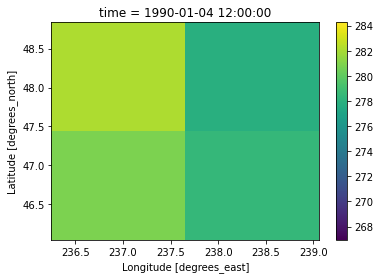

In [68]:
future_downscaled.isel(time=3).plot()   # this downscaling didn't work very well XD 

questions:
* which _remove_climatology() is it? and do we want to do this? how does removing the spatial anomaly work? it makes cold areas just colder (do it on seasonal mean basis?)
* why rolling mean for temp but not precip?

In [ ]:
# coarse_obs = obs_subset.reproject_match(train_subset)

# bias_corrected_coarse_model = coarse_model.quantile_map(coarse_obs)
fine_model = bias_corrected_coarse_model.interpolate(method='bilinear')
fine_anomaly = fine_obs - (coarse_obs.interpolate('bilinear')
fine_model_final = fine_model + fine_anomaly

In [62]:
train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads')#.interp_like(obs_subset.isel(time=0, drop=True)).chunk(chunks)

ValueError: some chunks keys are not dimensions on this object: {'y', 'x'}

In [ ]:
holdout_subset = ds_model[variable_ids[0]].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

In [ ]:
model = PointWiseDownscaler(
        TrendAwareQuantileMappingRegressor(QuantileMappingReressor(extrapolate=extrapolate[variable_ids[0]]))
    )

In [ ]:
for v in bc_vars:
    print(v)
    models[v] = PointWiseDownscaler(
        TrendAwareQuantileMappingRegressor(QuantileMappingReressor(extrapolate=extrapolate[variable_ids]))
    )

    # train models with historical data
    models[v].fit(x_hist[v].sel(time=train_time), y_hist[v].sel(time=train_time))

    # predict this ensemble member
    y_scen[v] = models[v].predict(x_scen[v])

In [ ]:
from skdownscale.pointwise_models import PointWiseDownscaler
from dask.diagnostics import ProgressBar

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation

model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))
model

In [ ]:
model.fit(train_subset, obs_subset)
display(model, model._models)

In [ ]:
def downscale(method_specs):
    downscale_model = get_model(method_specs, model_params=method_specs)
    downscale_model.prep() # calls regrid
    downscale_model.fit() # quantile mapping
    downscale_model.predict()
    downscale_model.eval()

In [ ]:
def get_model():
    ensure_consistency(method_specs, obs) # either check that params match obs or that obs can be coerced into matching specs
    return quantile_mapping # this will be a class

In [ ]:
def quantile_mapping(gcm, obs)

In [ ]:
# grab a gcm
# grab training data
downscale(method_specs={'name': 'quantile_mapping',  # when you regrid gets decided by the method 'chiao'
#                         'varibles':
#                         'spatial_resolution': ,
#                         'temporal_resolution':}, 
                        # which choices do we want to expose and test/run multiple permutations of
          gcm=gcm, 
          scenario=scenario, 
          region='global', 
         )
evaluate_performance() 
# gcm changes and metrics AND obs ;
# how well is it actually bias-corrected- what biases remain?
evaluate_changes() # store the change signal? 

thoughts:
* when to take from raw gcm grid to output - depends on method (maybe a downscaling method will keep it on its raw grid and find nearest neighbor or patterns?)
* what about other cmip6 experiments (not just scenario mip)